In [1]:
import stlearn as st
st.settings.set_figure_params(dpi=120)
# Reading data
data = st.Read10X(path="/home/d.pham/10X/BCBA/")
# Save raw_count
data.layers["raw_count"] = data.X
# Preprocessing
st.pp.filter_genes(data,min_cells=3)
st.pp.normalize_total(data)
st.pp.log1p(data)
# Keep raw data
data.raw = data
st.pp.scale(data)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Normalization step is finished in adata.X
Log transformation step is finished in adata.X
Scale step is finished in adata.X


In [2]:
# Run PCA
st.em.run_pca(data,n_comps=50,random_state=0)
# Tiling image
st.pp.tiling(data,out_path="tiling",crop_size = 40)
# Using Deep Learning to extract feature
st.pp.extract_feature(data)
# Apply stSME spatial-PCA option
st.spatial.morphology.adjust(data,use_data="X_pca",radius=50,method="mean")
st.pp.neighbors(data,n_neighbors=25,use_rep='X_pca_morphology',random_state=0)
st.tl.clustering.louvain(data,random_state=0)

Tiling image:   3%|▎          [ time left: 00:03 ]

PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


Tiling image: 100%|██████████ [ time left: 00:00 ]
Extract feature: 100%|██████████ [ time left: 00:00 ]
Adjusting data:   1%|           [ time left: 00:14 ]

The morphology feature is added to adata.obsm['X_morphology']!


Adjusting data: 100%|██████████ [ time left: 00:00 ]


The data adjusted by morphology is added to adata.obsm['X_pca_morphology']
Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 
Applying Louvain clustering ...
Louvain clustering is done! The labels are stored in adata.obs['louvain']


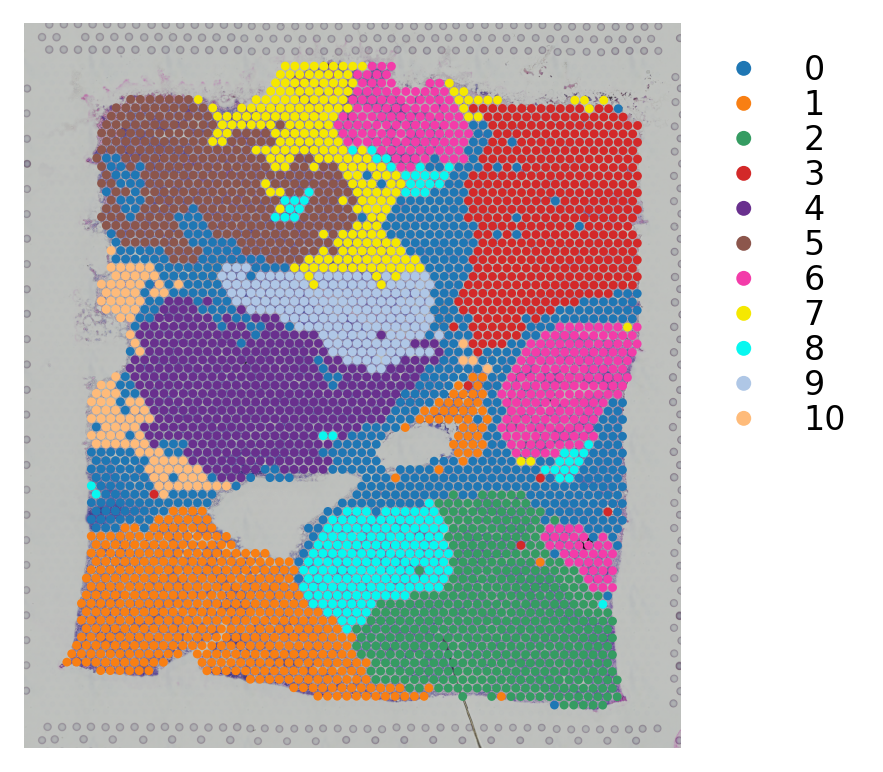

In [3]:
st.pl.cluster_plot(data,use_label="louvain",image_alpha=1,size=7)

In [4]:
data.uns["iroot"] = st.spatial.trajectory.set_root(data,use_label="louvain",cluster=6,use_raw=True)
st.spatial.trajectory.pseudotime(data,eps=50,use_rep="X_pca",use_label="louvain")

... storing 'feature_types' as categorical
... storing 'genome' as categorical


Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 
All available trajectory paths are stored in adata.uns['available_paths'] with length < 4 nodes


/home/d.pham/UQ/ST/Working/stLearn/stlearn/spatials/trajectory/pseudotime.py:196: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  v = np.array(list(dic.values()))
/home/d.pham/UQ/ST/Working/stLearn/stlearn/spatials/trajectory/pseudotime.py:196: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  v = np.array(list(dic.values()))


In [5]:
st.spatial.trajectory.pseudotimespace_global(data,use_label="louvain",list_clusters=["6","8"])

Screening:   2%|▏          [ time left: 00:07 ]

Screening PTS global graph...


Screening: 100%|██████████ [ time left: 00:00 ]
Calculating: 100%|██████████ [ time left: 00:00 ]


Calculate the graph dissimilarity using Laplacian matrix...
The optimized weighting is: 0.76
Start to construct the trajectory: 6 -> 8


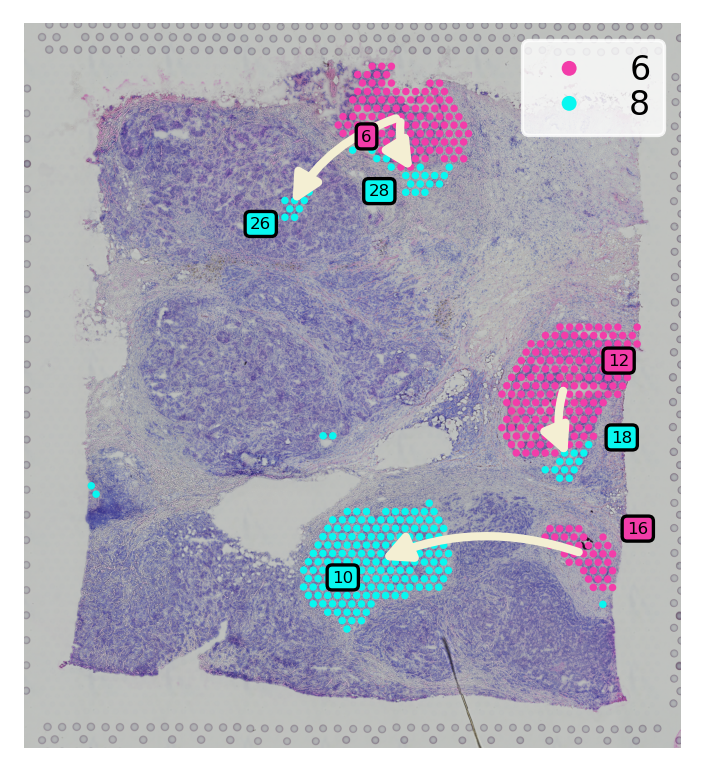

In [6]:
st.pl.cluster_plot(data,use_label="louvain",show_trajectories=True,list_clusters=["6","8"],show_subcluster=True)

In [7]:
non_mito_genes_list = [name for name in data.var_names if not name.startswith('RPL')]
non_mito_genes_list2 = [name for name in data.var_names if not name.startswith('RPS')]
non_mito_genes_list3 = [name for name in data.var_names if not name.startswith('MT-')]

In [8]:
final_genes = list(set(non_mito_genes_list) & set(non_mito_genes_list2) & set(non_mito_genes_list3))

In [9]:
data = data[:,final_genes]

In [10]:
st.spatial.trajectory.detect_transition_markers_clades(data,clade=6,use_raw_count=False,cutoff_spearman=0.3)

Detecting the transition markers of clade_6...


Trying to set attribute `.uns` of view, copying.


Transition markers result is stored in adata.uns['clade_6']


In [12]:
st.spatial.trajectory.detect_transition_markers_clades(data,clade=12,use_raw_count=False,cutoff_spearman=0.3)
st.spatial.trajectory.detect_transition_markers_clades(data,clade=16,use_raw_count=False,cutoff_spearman=0.3)

Detecting the transition markers of clade_12...
Transition markers result is stored in adata.uns['clade_12']
Detecting the transition markers of clade_16...
Transition markers result is stored in adata.uns['clade_16']


In [14]:
clade1 = data[data.obs.query("sub_cluster_labels == '6' | sub_cluster_labels == '25' | sub_cluster_labels == '28'").index,:]

In [15]:
clade2 = data[data.obs.query("sub_cluster_labels == '12' | sub_cluster_labels == '18'").index,:]

In [16]:
clade3 = data[data.obs.query("sub_cluster_labels == '16' | sub_cluster_labels == '10'").index,:]

## Clade 1

In [24]:
tmp = list(data.uns['clade_6'][:10].gene.values) + list(data.uns['clade_6'].sort_values("score")[:10].gene.values)
clade1_top_genes = clade1.to_df()[tmp]
import numpy as np

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
dpt = NormalizeData(clade1.obs["dpt_pseudotime"].values)
clade1_top_genes["dpt_pseudotime"] = dpt
clade1_top_genes = clade1_top_genes.sort_values("dpt_pseudotime")

In [32]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
scaler = MinMaxScaler()
col = clade1_top_genes.columns
clade1_top_genes = pd.DataFrame(scaler.fit_transform(clade1_top_genes).T)
clade1_top_genes.index = col

([], [])

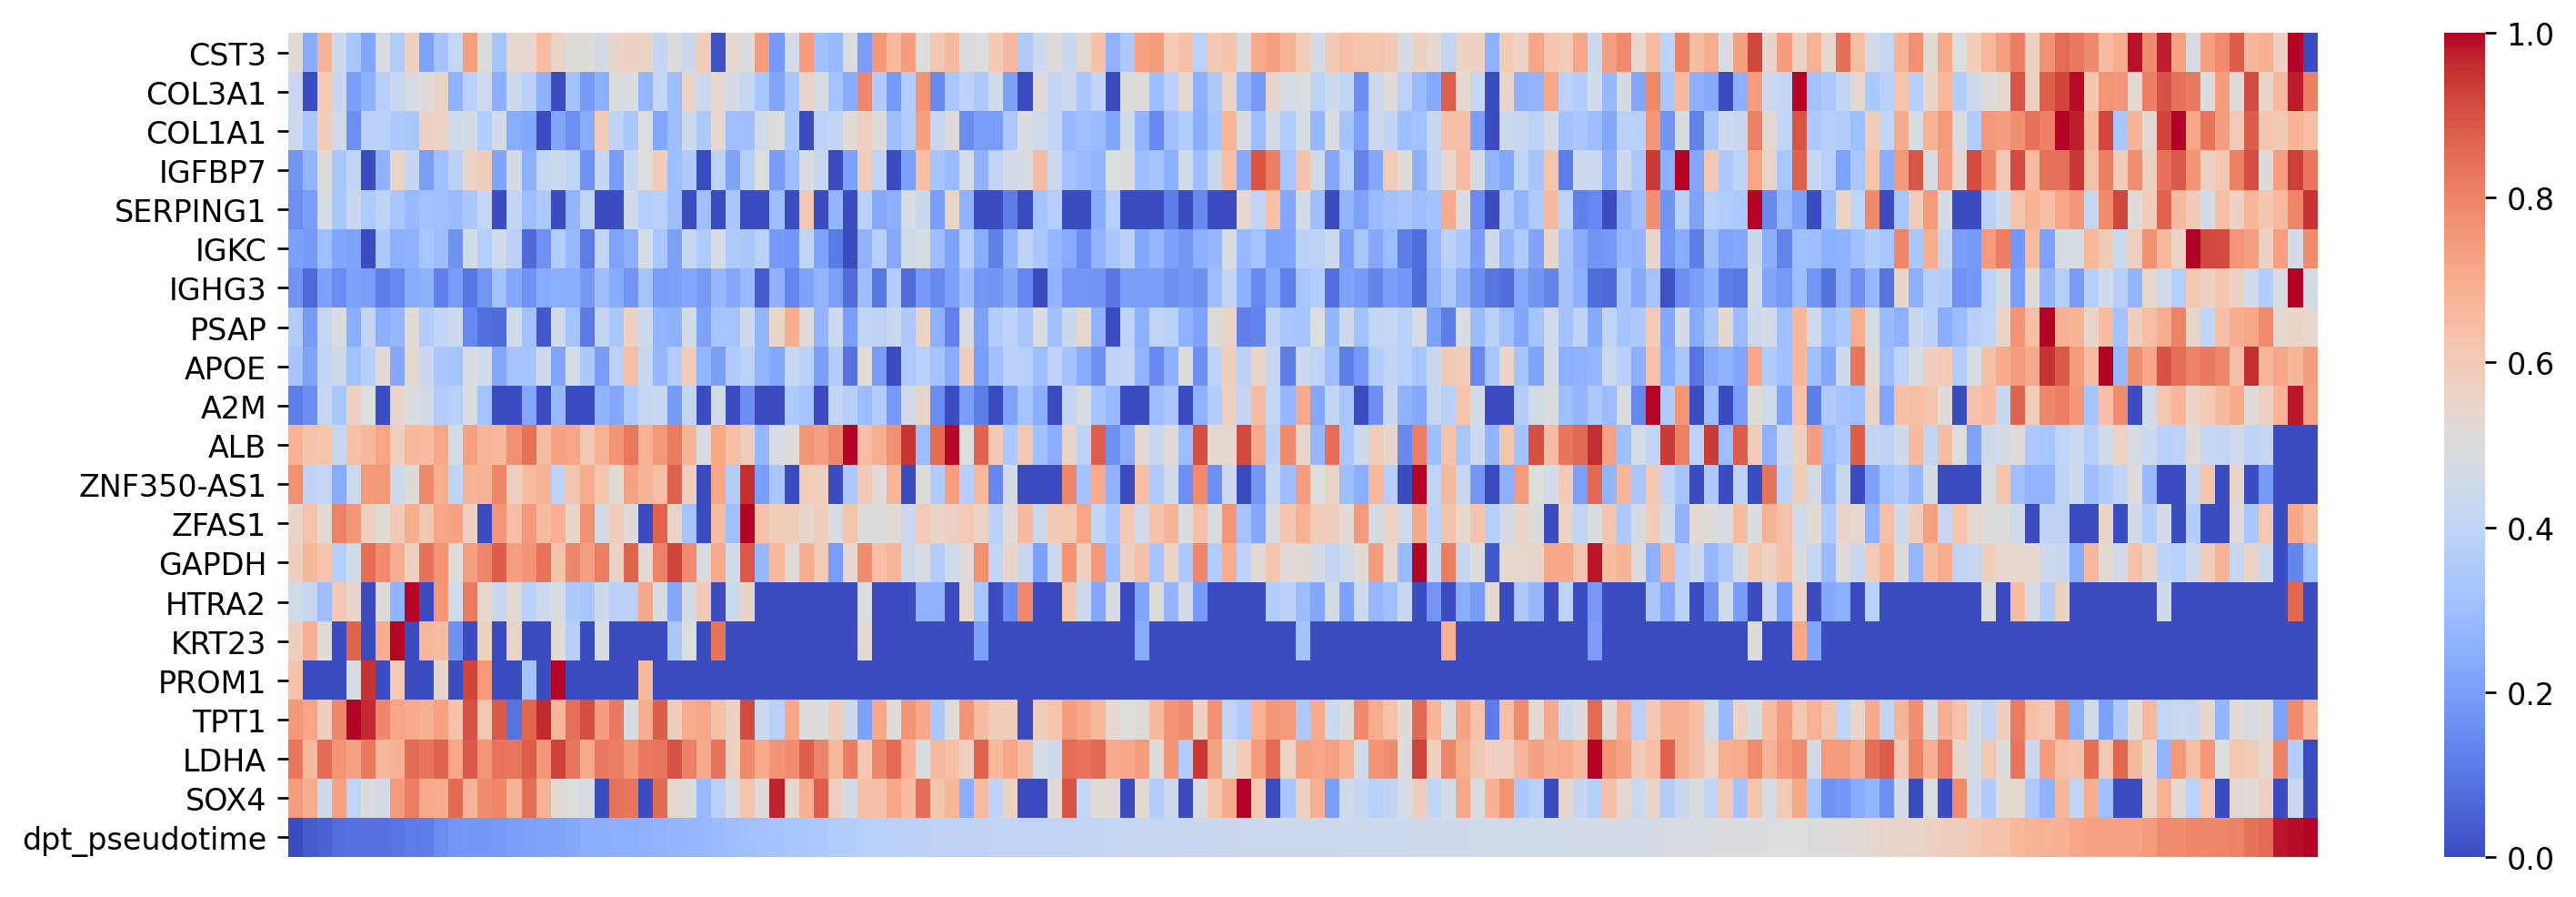

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.heatmap(clade1_top_genes,cmap="coolwarm")
plt.xticks([])

In [35]:
sub_16 = data[data.obs.query("sub_cluster_labels == '16'").index,:]

/home/d.pham/anaconda3/envs/stlearn/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


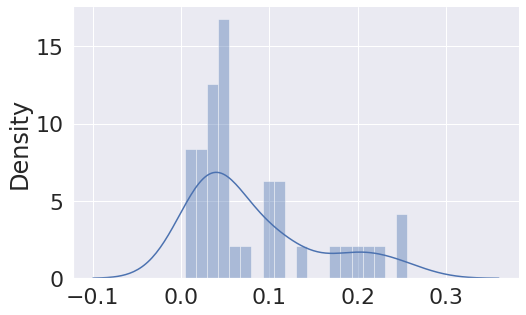

In [36]:
%matplotlib inline
sns.set(font_scale = 2)
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.distplot(sub_16.obs[["dpt_pseudotime"]],bins=20, kde=True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)



## Clade 2

In [41]:
tmp = list(data.uns['clade_12'][:10].gene.values) + list(data.uns['clade_12'].sort_values("score")[:10].gene.values)
clade2_top_genes = clade2.to_df()[tmp]
dpt = NormalizeData(clade2.obs["dpt_pseudotime"].values)
clade2_top_genes["dpt_pseudotime"] = dpt
clade2_top_genes = clade2_top_genes.sort_values("dpt_pseudotime")

In [42]:
scaler = MinMaxScaler()
col = clade2_top_genes.columns
clade2_top_genes = pd.DataFrame(scaler.fit_transform(clade2_top_genes).T)
clade2_top_genes.index = col

([], [])

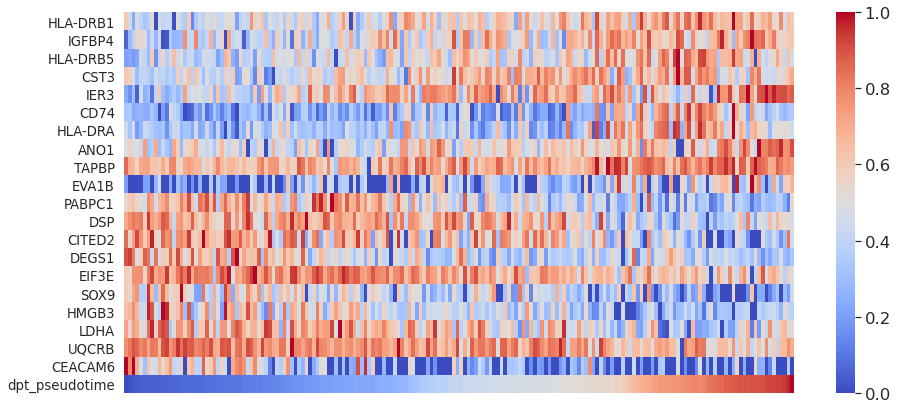

In [64]:
fig, ax = plt.subplots(figsize=(15,7))
sns.set(font_scale = 0.75)
ax = sns.heatmap(clade2_top_genes,cmap="coolwarm")
plt.xticks([])

In [65]:
sub_12 = data[data.obs.query("sub_cluster_labels == '12'").index,:]

/home/d.pham/anaconda3/envs/stlearn/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


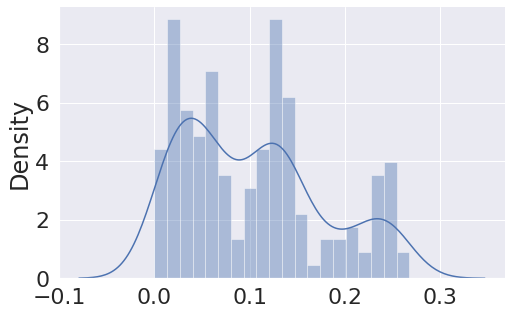

In [66]:
%matplotlib inline
sns.set(font_scale = 2)
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.distplot(sub_12.obs[["dpt_pseudotime"]],bins=20, kde=True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)



## Clade 3

In [67]:
tmp = list(data.uns['clade_16'][:10].gene.values) + list(data.uns['clade_16'].sort_values("score")[:10].gene.values)
clade3_top_genes = clade3.to_df()[tmp]
dpt = NormalizeData(clade3.obs["dpt_pseudotime"].values)
clade3_top_genes["dpt_pseudotime"] = dpt
clade3_top_genes = clade3_top_genes.sort_values("dpt_pseudotime")

In [68]:
scaler = MinMaxScaler()
col = clade3_top_genes.columns
clade3_top_genes = pd.DataFrame(scaler.fit_transform(clade3_top_genes).T)
clade3_top_genes.index = col

([], [])

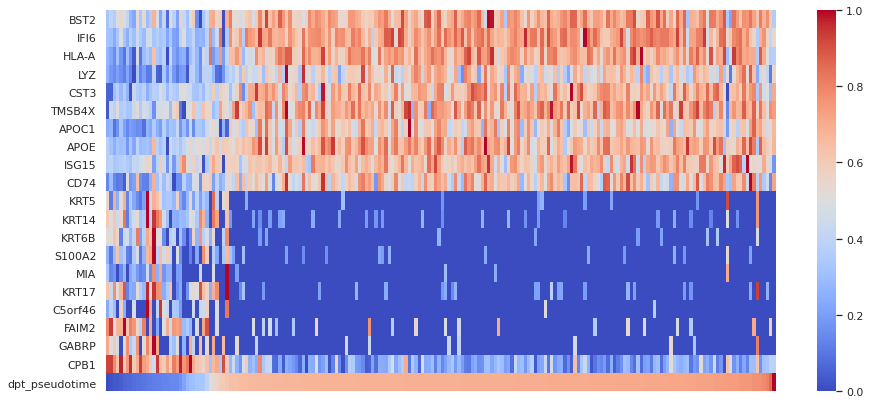

In [72]:
fig, ax = plt.subplots(figsize=(15,7))
sns.set(font_scale = 1)
ax = sns.heatmap(clade3_top_genes,cmap="coolwarm")
plt.xticks([])

In [73]:
sub_16 = data[data.obs.query("sub_cluster_labels == '16'").index,:]

/home/d.pham/anaconda3/envs/stlearn/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


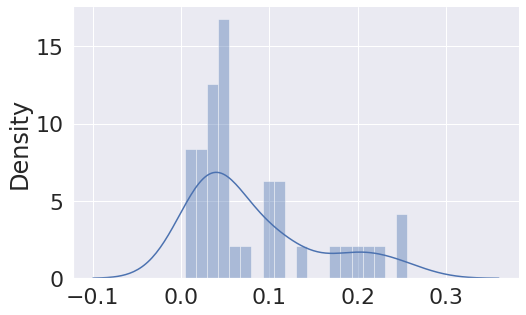

In [74]:
%matplotlib inline
sns.set(font_scale = 2)
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.distplot(sub_16.obs[["dpt_pseudotime"]],bins=20, kde=True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)